### Loading liberary and dataset


In [1]:
library(ISLR2)
library(MASS)
library(class)



Attaching package: ‘MASS’


The following object is masked from ‘package:ISLR2’:

    Boston




### Dataset info


In [2]:
names(Smarket)
dim(Smarket)

# Attach the dataset
attach(Smarket)


[1] "Year"      "Lag1"      "Lag2"      "Lag3"      "Lag4"      "Lag5"     
[7] "Volume"    "Today"     "Direction"

[1] 1250    9

### Log linear regression


In [3]:
logistic.fit <- glm(Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume, data = Smarket, family = binomial)
summary(logistic.fit)



Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Smarket)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.446  -1.203   1.065   1.145   1.326  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.126000   0.240736  -0.523    0.601
Lag1        -0.073074   0.050167  -1.457    0.145
Lag2        -0.042301   0.050086  -0.845    0.398
Lag3         0.011085   0.049939   0.222    0.824
Lag4         0.009359   0.049974   0.187    0.851
Lag5         0.010313   0.049511   0.208    0.835
Volume       0.135441   0.158360   0.855    0.392

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1731.2  on 1249  degrees of freedom
Residual deviance: 1727.6  on 1243  degrees of freedom
AIC: 1741.6

Number of Fisher Scoring iterations: 3


### Predictions base on glm


In [4]:
logistic.probs <- predict(logistic.fit, type = "response")
logistic.probs[1:10]



1         2         3         4         5         6         7         8 
0.5070841 0.4814679 0.4811388 0.5152224 0.5107812 0.5069565 0.4926509 0.5092292 
        9        10 
0.5176135 0.4888378

#### check dummy variable


In [5]:
contrasts(Direction)


,Up
Down,0
Up,1


### Convert the prob to class


In [6]:
# Create all "down" array
logistic.pred <- rep("Down", 1250)

# Set threshold 0.5
logistic.pred[logistic.probs > 0.5] <- "Up"


### Confusion matrix and prediction accuracy


In [7]:
table(logistic.pred, Direction)
mean(logistic.pred == Direction)


             Direction
logistic.pred Down  Up
         Down  145 141
         Up    457 507

[1] 0.5216

### Cross Validation


#### Step 1: Split data (2001~2004 for training, 2005 for test)


In [8]:
train <- (Year < 2005)
Smarket.2005 <- Smarket[!train, ]
Direction.2005 <- Direction[!train]


#### Step 2: Train model on training data


In [9]:
logistic.fit <- glm(Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume, data = Smarket, family = binomial, subset = train)


#### tep 3: Make Prediction on test data


In [10]:
logistic.probs <- predict(logistic.fit, Smarket.2005, type = "response")
logistic.pred <- rep("Down", 252)

# Length(Direction.2005)
logistic.pred[logistic.probs > 0.5] <- "Up"


#### Step 4: Assess prediction accuracy


In [11]:
table(logistic.pred, Direction.2005)
mean(logistic.pred == Direction.2005)


             Direction.2005
logistic.pred Down Up
         Down   77 97
         Up     34 44

[1] 0.4801587

### LDA and QDA


#### Step 1 - Obtain dataset and Split it


#### Step 2 - Train model and predict


In [12]:
lda.fit <- lda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)
lda.pred <- predict(lda.fit, Smarket.2005)
names(lda.pred)

# See what prediction contains
# lda.pred$class
# lda.pred$posterior


[1] "class"     "posterior" "x"

#### Step 3 - Calculate prediction accuracy


In [13]:
lda.class <- lda.pred$class
table(lda.class, Direction.2005)
mean(lda.class == Direction.2005)


         Direction.2005
lda.class Down  Up
     Down   35  35
     Up     76 106

[1] 0.5595238

#### Step 4 - Change threshold (Extra)


In [14]:
lda.class <- rep("Down", length(Direction.2005))
lda.class[lda.pred$posterior[, 2] > 0.49] <- "Up"
table(lda.class, Direction.2005)
mean(lda.class == Direction.2005)


         Direction.2005
lda.class Down  Up
     Down    5   5
     Up    106 136

[1] 0.5595238

### ROC curve of Logistic Regression


        Predicted
Observed   0   1
    Down 114 488
    Up    97 551


FPR       TPR 
0.8106312 0.8503086

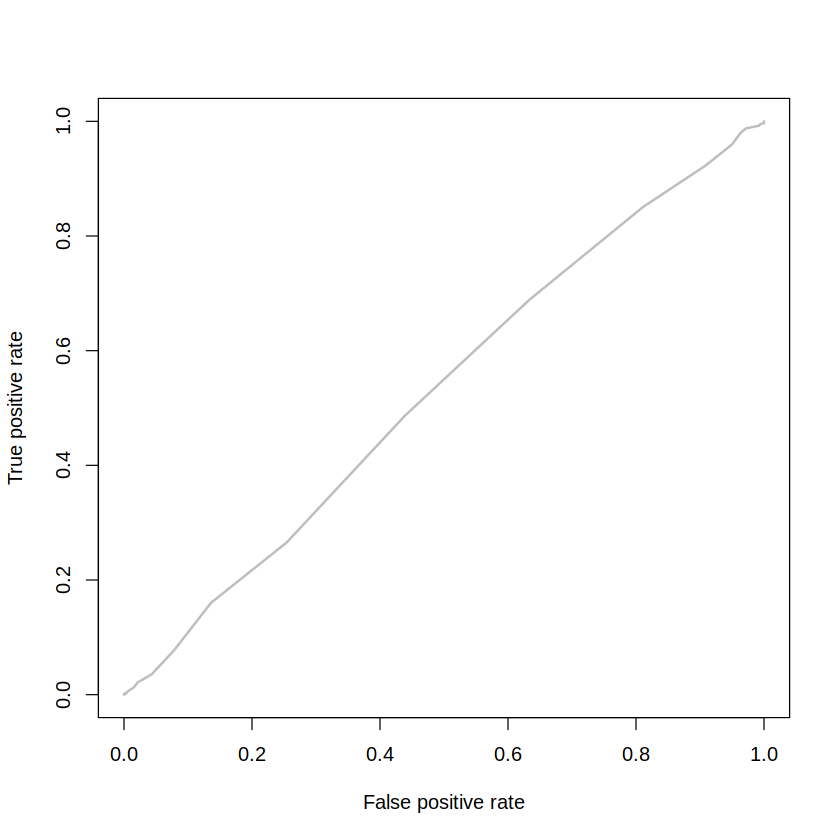

In [15]:
# fit logistic regression to all data (2001~2005)
LR.fit <- glm(Direction ~ Lag1 + Lag2 + Lag3, family = binomial, data = Smarket)
# predict probability of "UP"
LR.pred <- predict(LR.fit, type = "response")

# Calculate FPR and TPR under a given threshold
roc.curve <- function(s, print = FALSE) {
    Ps <- (LR.pred > s) * 1
    FP <- sum((Ps == 1) * (Direction == "Down")) / sum(Direction == "Down")
    TP <- sum((Ps == 1) * (Direction == "Up")) / sum(Direction == "Up")
    if (print == TRUE) {
        print(table(Observed = Direction, Predicted = Ps))
    }
    vect <- c(FP, TP)
    names(vect) <- c("FPR", "TPR")
    return(vect)
}

threshold <- 0.5
roc.curve(threshold, print = TRUE)

# Plot ROC curve
ROC.curve <- Vectorize(roc.curve)
M.ROC <- ROC.curve(seq(0, 1, by = 0.01))
plot(M.ROC[1, ], M.ROC[2, ], col = "grey", lwd = 2, type = "l", xlab = "False positive rate", ylab = "True positive rate")


### ROC curve of LDA


        Predicted
Observed   0   1
    Down 111 491
    Up    97 551


FPR       TPR 
0.8156146 0.8503086

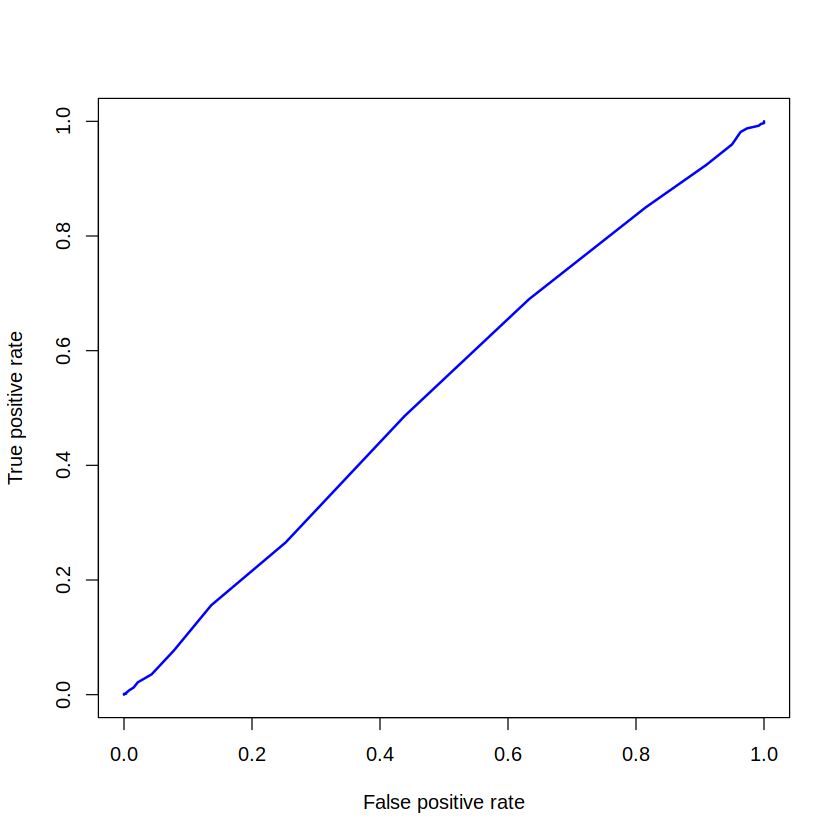

In [16]:
LDA.fit <- lda(Direction ~ Lag1 + Lag2 + Lag3, data = Smarket)
# Predict probabilities of training data
LDA.pred0 <- predict(LDA.fit, type = "response")
LDA.pred <- LDA.pred0$posterior[, 2]

# Calculate FPR and TPR under a given threshold
roc.curve <- function(s, print = FALSE) {
    Ps <- (LDA.pred > s) * 1
    FP <- sum((Ps == 1) * (Direction == "Down")) / sum(Direction == "Down")
    TP <- sum((Ps == 1) * (Direction == "Up")) / sum(Direction == "Up")
    if (print == TRUE) {
        print(table(Observed = Direction, Predicted = Ps))
    }
    vect <- c(FP, TP)
    names(vect) <- c("FPR", "TPR")
    return(vect)
}

threshold <- 0.5
roc.curve(threshold, print = TRUE)

# Plot ROC Curve
ROC.curve <- Vectorize(roc.curve)
M.ROC <- ROC.curve(seq(0, 1, by = 0.01))
plot(M.ROC[1, ], M.ROC[2, ], col = "blue", lwd = 2, type = "l", xlab = "False positive rate", ylab = "True positive rate")


### KNN


In [17]:
train <- (Year < 2005)

# Training data of observation
train.X <- cbind(Lag1, Lag2)[train, ]

# Test data of observation
test.X <- cbind(Lag1, Lag2)[!train, ]

# Training data of response
train.Direction <- Direction[train]

# Predict accuracy
knn.pred1 <- knn(train.X, test.X, train.Direction, k = 1)
table(knn.pred1, Direction.2005)
mean(knn.pred1 == Direction.2005)

# Change k to 3
knn.pred2 <- knn(train.X, test.X, train.Direction, k = 3)
table(knn.pred2, Direction.2005)
mean(knn.pred2 == Direction.2005)

# Change k to 5
knn.pred2 <- knn(train.X, test.X, train.Direction, k = 5)
table(knn.pred2, Direction.2005)
mean(knn.pred2 == Direction.2005)


         Direction.2005
knn.pred1 Down Up
     Down   43 58
     Up     68 83

[1] 0.5

         Direction.2005
knn.pred2 Down Up
     Down   48 54
     Up     63 87

[1] 0.5357143

         Direction.2005
knn.pred2 Down Up
     Down   40 59
     Up     71 82

[1] 0.484127